# <center>Analyzing Toronto Neighborhoods</center>

#### <center>by Sushant Deshpande</center>

### Let's start by importing libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium # map rendering library
print('Libraries imported.')

Libraries imported.


# Optional Libraries
import requests
from collections import defaultdict
import requests
from urllib.request import urlopen
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes

### Accessing the webpage
Let's access the wikipedia paage that lista all the postal codes for Toronto and save it in a pandas dataframe

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
tables = pd.read_html(url)
table_df = tables[0]
table_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Data cleanup

Split the dataframe and delete unwanted columns. Delete \n] and [

In [3]:
table_df.columns = ['PostalCode', 'Borough', 'Neighborhood']
table_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


I downloaded the Geospatial_Coordinates.csv file and renamed the headers to PostalCode, Latitude, Longitude. We need to make sure that the datatypes of Latitude and Longitude are float. So I merged the imported csv file with my final dataframe on PostalCode i.e. merge the 2 dataframes in such a way that Postal code remains the same and the Latitude and Longitude for that PostalCode anr in corresponding cells.

In [4]:
cor_df = pd.read_csv("Geospatial_Coordinates.csv")
cor_df.columns = ['PostalCode', 'Latitude', 'Longitude']
data_df = pd.merge(table_df, cor_df, on=['PostalCode'])
data_df[['Latitude', 'Longitude']] = data_df[['Latitude', 'Longitude']].astype(float)
data_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [5]:
address = 'Toronto, ON'

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinate of', address, 'are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON are 43.6534817, -79.3839347.


Now, let's analyze the east and west parts of Toronto. For this, we create a new data frames with Borough saying West Toronto and East Toronto.

In [6]:
data_west = data_df[data_df['Borough'].str.contains('West Toronto')].reset_index(drop=True)
data_west.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
1,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750
2,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191
3,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763
4,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325


In [7]:
data_east = data_df[data_df['Borough'].str.contains('East Toronto')].reset_index(drop=True)
data_east.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558


Now, let's visualize it on a map.

In [8]:
# create map of Toronto using latitude and longitude values
map_west = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(data_west['Latitude'],
                                           data_west['Longitude'],
                                           data_west['Borough'],
                                           data_west['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_west)  
    
map_west

In [9]:
# create map of Toronto using latitude and longitude values
map_east = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(data_east['Latitude'],
                                           data_east['Longitude'],
                                           data_east['Borough'],
                                           data_east['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_east)  
    
map_east

#### Now, let's leverage the power of FourSquare!

In [10]:
# @hidden_cell
from config import CLIENT_ID, CLIENT_SECRET
VERSION = '20180604'
LIMIT = 50000

Let's take the first cell from each cell and see analyze it.

In [11]:
data_east.loc[0, 'Neighborhood']

'The Beaches'

In [12]:
data_west.loc[0, 'Neighborhood']

'Dufferin, Dovercourt Village'

In [13]:
neighborhood_latitude_east = data_east.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude_east = data_east.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name_east = data_east.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name_east, 
                                                               neighborhood_latitude_east, 
                                                               neighborhood_longitude_east))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


In [14]:
neighborhood_latitude_west = data_west.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude_west = data_west.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name_west = data_west.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name_west, 
                                                               neighborhood_latitude_west, 
                                                               neighborhood_longitude_west))

Latitude and longitude values of Dufferin, Dovercourt Village are 43.66900510000001, -79.4422593.


In [15]:
LIMIT = 100
radius = 1000

url_4s_east = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude_east, 
    neighborhood_longitude_east, 
    radius, 
    LIMIT)

In [16]:
LIMIT = 100
radius = 1000

url_4s_west = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude_west, 
    neighborhood_longitude_west, 
    radius, 
    LIMIT)

In [17]:
results_east = requests.get(url_4s_east).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues_east = results_east['response']['groups'][0]['items']
nearby_venues_east = json_normalize(venues_east) # flatten JSON
# filter columns
filtered_columns_east = ['venue.name',
                    'venue.categories',
                    'venue.location.lat',
                    'venue.location.lng']
nearby_venues_east =nearby_venues_east.loc[:, filtered_columns_east]
# filter the category for each row
nearby_venues_east['venue.categories'] = nearby_venues_east.apply(get_category_type, axis=1)
# clean columns
nearby_venues_east.columns = [col.split(".")[-1] for col in nearby_venues_east.columns]
nearby_venues_east.head()

,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,Tori's Bakeshop,Vegetarian / Vegan Restaurant,43.672114,-79.290331
2,The Fox Theatre,Indie Movie Theater,43.672801,-79.287272
3,Ed's Real Scoop,Ice Cream Shop,43.672630,-79.287993
4,Beaches Bake Shop,Bakery,43.680363,-79.289692


In [18]:
results_west = requests.get(url_4s_west).json()

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues_west = results_west['response']['groups'][0]['items']
nearby_venues_west = json_normalize(venues_west) # flatten JSON
# filter columns
filtered_columns_west = ['venue.name',
                    'venue.categories',
                    'venue.location.lat',
                    'venue.location.lng']
nearby_venues_west =nearby_venues_west.loc[:, filtered_columns_west]
# filter the category for each row
nearby_venues_west['venue.categories'] = nearby_venues_west.apply(get_category_type, axis=1)
# clean columns
nearby_venues_west.columns = [col.split(".")[-1] for col in nearby_venues_west.columns]
nearby_venues_west.head()

,name,categories,lat,lng
0,The Greater Good Bar,Bar,43.669409,-79.439267
1,Parallel,Middle Eastern Restaurant,43.669516,-79.438728
2,Blood Brothers Brewing,Brewery,43.669944,-79.436533
3,Balzac’s Coffee,Coffee Shop,43.670042,-79.448342
4,Hale Coffee,Coffee Shop,43.665532,-79.449949


In [19]:
nearby_venues_west.shape

(65, 4)

In [20]:
print('East Toronto has {} venues,'.format(nearby_venues_east.shape[0]), 'and West Toronto has {} venues.'.format(nearby_venues_west.shape[0]))

East Toronto has 75 venues, and West Toronto has 65 venues.


As we can see above, East Toronto has 85 venues, and West Toronto has 70 venues.

In [21]:
def getNearbyVenues_east(names, latitudes, longitudes, radius=1000):
    
    venues_list_east=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        url_4s1_east = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results_east = requests.get(url_4s1_east).json()["response"]['groups'][0]['items']

        venues_list_east.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results_east])

    nearby_venues_east = pd.DataFrame([item for venues_list_east in venues_list_east for item in venues_list_east])
    nearby_venues_east.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues_east)

In [22]:
def getNearbyVenues_west(names, latitudes, longitudes, radius=1000):
    
    venues_list_west=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        url_4s1_west = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results_west = requests.get(url_4s1_west).json()["response"]['groups'][0]['items']

        venues_list_west.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results_west])

    nearby_venues_west = pd.DataFrame([item for venues_list_west in venues_list_west for item in venues_list_west])
    nearby_venues_west.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues_west)

In [23]:
toronto_venues_east = getNearbyVenues_east(names=data_east['Neighborhood'],
                                   latitudes=data_east['Latitude'],
                                   longitudes=data_east['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Business reply mail Processing Centre, South Central Letter Processing Plant Toronto


In [24]:
toronto_venues_west = getNearbyVenues_west(names=data_west['Neighborhood'],
                                   latitudes=data_west['Latitude'],
                                   longitudes=data_west['Longitude']
                                  )

Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High Park, The Junction South
Parkdale, Roncesvalles
Runnymede, Swansea


In [25]:
toronto_venues_east.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,Tori's Bakeshop,43.672114,-79.290331,Vegetarian / Vegan Restaurant
2,The Beaches,43.676357,-79.293031,The Fox Theatre,43.672801,-79.287272,Indie Movie Theater
3,The Beaches,43.676357,-79.293031,Ed's Real Scoop,43.672630,-79.287993,Ice Cream Shop
4,The Beaches,43.676357,-79.293031,Beaches Bake Shop,43.680363,-79.289692,Bakery


In [26]:
toronto_venues_west.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Dufferin, Dovercourt Village",43.669005,-79.442259,The Greater Good Bar,43.669409,-79.439267,Bar
1,"Dufferin, Dovercourt Village",43.669005,-79.442259,Parallel,43.669516,-79.438728,Middle Eastern Restaurant
2,"Dufferin, Dovercourt Village",43.669005,-79.442259,Blood Brothers Brewing,43.669944,-79.436533,Brewery
3,"Dufferin, Dovercourt Village",43.669005,-79.442259,Balzac’s Coffee,43.670042,-79.448342,Coffee Shop
4,"Dufferin, Dovercourt Village",43.669005,-79.442259,Hale Coffee,43.665532,-79.449949,Coffee Shop


In [27]:
toronto_venues_east.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(toronto_venues_east['Venue Category'].unique())))

There are 128 uniques categories.


In [28]:
toronto_venues_west.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(toronto_venues_west['Venue Category'].unique())))

There are 156 uniques categories.


In [29]:
# one hot encoding
toronto_onehot_east = pd.get_dummies(toronto_venues_east[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot_east['Neighborhood'] = toronto_venues_east['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns_east = [toronto_onehot_east.columns[-1]] + list(toronto_onehot_east.columns[:-1])
toronto_onehot_east = toronto_onehot_east[fixed_columns_east]

toronto_onehot_east.head()

,Yoga Studio,American Restaurant,Antique Shop,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,...,Tapas Restaurant,Tea Room,Thai Restaurant,Toy / Game Store,Trail,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# one hot encoding
toronto_onehot_west = pd.get_dummies(toronto_venues_west[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot_west['Neighborhood'] = toronto_venues_west['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns_west = [toronto_onehot_west.columns[-1]] + list(toronto_onehot_west.columns[:-1])
toronto_onehot_west = toronto_onehot_west[fixed_columns_west]

toronto_onehot_west.head()

,Zoo,Accessories Store,American Restaurant,Amphitheater,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Thai Restaurant,Theater,Thrift / Vintage Store,Tibetan Restaurant,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
toronto_grouped_east = toronto_onehot_east.groupby('Neighborhood').mean().reset_index()
num_top_venues_east = 5

for hood in toronto_grouped_east['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped_east[toronto_grouped_east['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues_east))
    print('\n')

----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
              venue  freq
0              Park  0.10
1       Coffee Shop  0.08
2       Pizza Place  0.06
3           Brewery  0.06
4  Sushi Restaurant  0.04


----India Bazaar, The Beaches West----
               venue  freq
0  Indian Restaurant  0.11
1        Coffee Shop  0.05
2              Beach  0.04
3         Restaurant  0.04
4               Park  0.04


----Studio District----
                 venue  freq
0          Coffee Shop  0.07
1                  Bar  0.05
2              Brewery  0.05
3  American Restaurant  0.05
4                Diner  0.04


----The Beaches----
                 venue  freq
0                  Pub  0.08
1          Coffee Shop  0.07
2          Pizza Place  0.05
3  Japanese Restaurant  0.04
4       Breakfast Spot  0.04


----The Danforth West, Riverdale----
              venue  freq
0  Greek Restaurant  0.10
1       Coffee Shop  0.07
2              Café  0.06
3        

In [32]:
toronto_grouped_west = toronto_onehot_west.groupby('Neighborhood').mean().reset_index()
num_top_venues_west = 5

for hood in toronto_grouped_west['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped_west[toronto_grouped_west['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues_west))
    print('\n')

----Brockton, Parkdale Village, Exhibition Place----
                    venue  freq
0             Coffee Shop  0.07
1                    Café  0.07
2                     Bar  0.05
3              Restaurant  0.04
4  Furniture / Home Store  0.04


----Dufferin, Dovercourt Village----
                venue  freq
0         Coffee Shop  0.11
1                Café  0.11
2                Park  0.08
3  Italian Restaurant  0.05
4                 Bar  0.05


----High Park, The Junction South----
               venue  freq
0               Café  0.08
1                Bar  0.07
2        Coffee Shop  0.05
3  Convenience Store  0.04
4    Thai Restaurant  0.04


----Little Portugal, Trinity----
         venue  freq
0         Café  0.08
1   Restaurant  0.06
2          Bar  0.05
3  Coffee Shop  0.04
4       Bakery  0.04


----Parkdale, Roncesvalles----
              venue  freq
0              Café  0.05
1       Pizza Place  0.05
2       Coffee Shop  0.04
3  Sushi Restaurant  0.04
4               Bar  0

### Now, let's a get a list of top 10 venues in east and west Toronto

In [33]:
def return_most_common_venues_east(row, num_top_venues_east):
    row_categories_east = row.iloc[1:]
    row_categories_sorted_east = row_categories_east.sort_values(ascending=False)
    
    return row_categories_sorted_east.index.values[0:num_top_venues_east]

In [34]:
def return_most_common_venues_west(row, num_top_venues_west):
    row_categories_west = row.iloc[1:]
    row_categories_sorted_west = row_categories_west.sort_values(ascending=False)
    
    return row_categories_sorted_west.index.values[0:num_top_venues_west]

In [35]:
num_top_venues_east = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues_east):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_east = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_east['Neighborhood'] = toronto_grouped_east['Neighborhood']

for ind in np.arange(toronto_grouped_east.shape[0]):
    neighborhoods_venues_sorted_east.iloc[ind, 1:] = return_most_common_venues_east(toronto_grouped_east.iloc[ind, :], num_top_venues_east)

neighborhoods_venues_sorted_east

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Business reply mail Processing Centre, South C...",Park,Coffee Shop,Pizza Place,Brewery,Italian Restaurant,Bakery,Sushi Restaurant,Fast Food Restaurant,Juice Bar,Liquor Store
1,"India Bazaar, The Beaches West",Indian Restaurant,Coffee Shop,Park,Grocery Store,Restaurant,Beach,Brewery,Café,Sandwich Place,Burrito Place
2,Studio District,Coffee Shop,Brewery,American Restaurant,Bar,Diner,Bakery,Vietnamese Restaurant,Sushi Restaurant,French Restaurant,Café
3,The Beaches,Pub,Coffee Shop,Pizza Place,Breakfast Spot,Beach,Japanese Restaurant,Health Food Store,Sandwich Place,Bar,Park
4,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Café,Pub,Bank,Italian Restaurant,Yoga Studio,Ice Cream Shop,Bookstore,Pizza Place


In [36]:
num_top_venues_west = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues_west):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_west = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_west['Neighborhood'] = toronto_grouped_west['Neighborhood']

for ind in np.arange(toronto_grouped_west.shape[0]):
    neighborhoods_venues_sorted_west.iloc[ind, 1:] = return_most_common_venues_west(toronto_grouped_west.iloc[ind, :], num_top_venues_west)

neighborhoods_venues_sorted_west

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Bar,Bakery,Furniture / Home Store,Restaurant,Gift Shop,Tibetan Restaurant,Park,Sandwich Place
1,"Dufferin, Dovercourt Village",Café,Coffee Shop,Park,Bar,Italian Restaurant,Sushi Restaurant,Grocery Store,Brewery,Portuguese Restaurant,Bakery
2,"High Park, The Junction South",Café,Bar,Coffee Shop,Thai Restaurant,Convenience Store,Bakery,Park,Italian Restaurant,Sushi Restaurant,Cajun / Creole Restaurant
3,"Little Portugal, Trinity",Café,Restaurant,Bar,Italian Restaurant,Bakery,Coffee Shop,Asian Restaurant,Cocktail Bar,Vegetarian / Vegan Restaurant,Pizza Place
4,"Parkdale, Roncesvalles",Café,Pizza Place,Coffee Shop,Breakfast Spot,Bar,Sushi Restaurant,Eastern European Restaurant,Pub,Thai Restaurant,Grocery Store
5,"Runnymede, Swansea",Coffee Shop,Café,Bakery,Pizza Place,Italian Restaurant,Pub,Sushi Restaurant,Restaurant,Falafel Restaurant,Bank


In [37]:
kclusters = 5

toronto_grouped_clustering_east = toronto_grouped_east.drop('Neighborhood', 1)

kmeans_east = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering_east)

kmeans_east.labels_[0:10]

array([3, 2, 1, 4, 0], dtype=int32)

In [38]:
kclusters = 5

toronto_grouped_clustering_west = toronto_grouped_west.drop('Neighborhood', 1)

kmeans_west = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering_west)

kmeans_west.labels_[0:10]

array([2, 3, 1, 2, 0, 4], dtype=int32)

In [39]:
toronto_merged_east = data_east

toronto_merged_east['Cluster Labels'] = kmeans_east.labels_

toronto_merged_east = toronto_merged_east.join(neighborhoods_venues_sorted_east.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_east.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Pub,Coffee Shop,Pizza Place,Breakfast Spot,Beach,Japanese Restaurant,Health Food Store,Sandwich Place,Bar,Park
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Coffee Shop,Café,Pub,Bank,Italian Restaurant,Yoga Studio,Ice Cream Shop,Bookstore,Pizza Place
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,1,Indian Restaurant,Coffee Shop,Park,Grocery Store,Restaurant,Beach,Brewery,Café,Sandwich Place,Burrito Place
3,M4M,East Toronto,Studio District,43.659526,-79.340923,4,Coffee Shop,Brewery,American Restaurant,Bar,Diner,Bakery,Vietnamese Restaurant,Sushi Restaurant,French Restaurant,Café
4,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558,0,Park,Coffee Shop,Pizza Place,Brewery,Italian Restaurant,Bakery,Sushi Restaurant,Fast Food Restaurant,Juice Bar,Liquor Store


In [40]:
toronto_merged_west = data_west

toronto_merged_west['Cluster Labels'] = kmeans_west.labels_

toronto_merged_west = toronto_merged_west.join(neighborhoods_venues_sorted_west.set_index('Neighborhood'), on='Neighborhood')

toronto_merged_west.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,2,Café,Coffee Shop,Park,Bar,Italian Restaurant,Sushi Restaurant,Grocery Store,Brewery,Portuguese Restaurant,Bakery
1,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,3,Café,Restaurant,Bar,Italian Restaurant,Bakery,Coffee Shop,Asian Restaurant,Cocktail Bar,Vegetarian / Vegan Restaurant,Pizza Place
2,M6K,West Toronto,"Brockton, Parkdale Village, Exhibition Place",43.636847,-79.428191,1,Café,Coffee Shop,Bar,Bakery,Furniture / Home Store,Restaurant,Gift Shop,Tibetan Restaurant,Park,Sandwich Place
3,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,2,Café,Bar,Coffee Shop,Thai Restaurant,Convenience Store,Bakery,Park,Italian Restaurant,Sushi Restaurant,Cajun / Creole Restaurant
4,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,0,Café,Pizza Place,Coffee Shop,Breakfast Spot,Bar,Sushi Restaurant,Eastern European Restaurant,Pub,Thai Restaurant,Grocery Store


In [41]:
map_clusters_east = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_east['Latitude'],
                                  toronto_merged_east['Longitude'],
                                  toronto_merged_east['Neighborhood'],
                                  toronto_merged_east['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_east)
       
map_clusters_east

In [42]:
map_clusters_west = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged_west['Latitude'],
                                  toronto_merged_west['Longitude'],
                                  toronto_merged_west['Neighborhood'],
                                  toronto_merged_west['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_west)
       
map_clusters_west

In [43]:
toronto_east_group = toronto_venues_east.groupby('Venue Category').count()
print('There are {} uniques categories.'.format(len(toronto_venues_east['Venue Category'].unique())))

There are 128 uniques categories.


In [44]:
toronto_west_group = toronto_venues_west.groupby('Venue Category').count()
print('There are {} uniques categories.'.format(len(toronto_venues_west['Venue Category'].unique())))

There are 156 uniques categories.


In [45]:
toronto_east_group.sort_values(by='Neighborhood', ascending=True, inplace=True)

df_top10_east = toronto_east_group['Neighborhood'].tail(10)
df_top10_east

Venue Category
Italian Restaurant     9
Pizza Place           11
Greek Restaurant      11
Indian Restaurant     11
Brewery               11
Bakery                12
Café                  12
Pub                   13
Park                  13
Coffee Shop           27
Name: Neighborhood, dtype: int64

In [46]:
toronto_west_group.sort_values(by='Neighborhood', ascending=True, inplace=True)

df_top10_west = toronto_west_group['Neighborhood'].tail(10)
df_top10_west

Venue Category
Thai Restaurant       10
Sushi Restaurant      12
Pizza Place           13
Park                  14
Italian Restaurant    16
Restaurant            16
Bakery                20
Bar                   25
Coffee Shop           36
Café                  42
Name: Neighborhood, dtype: int64

#### Let’s try to plot them using bar graph to make them more visually appealing and easy to understand.

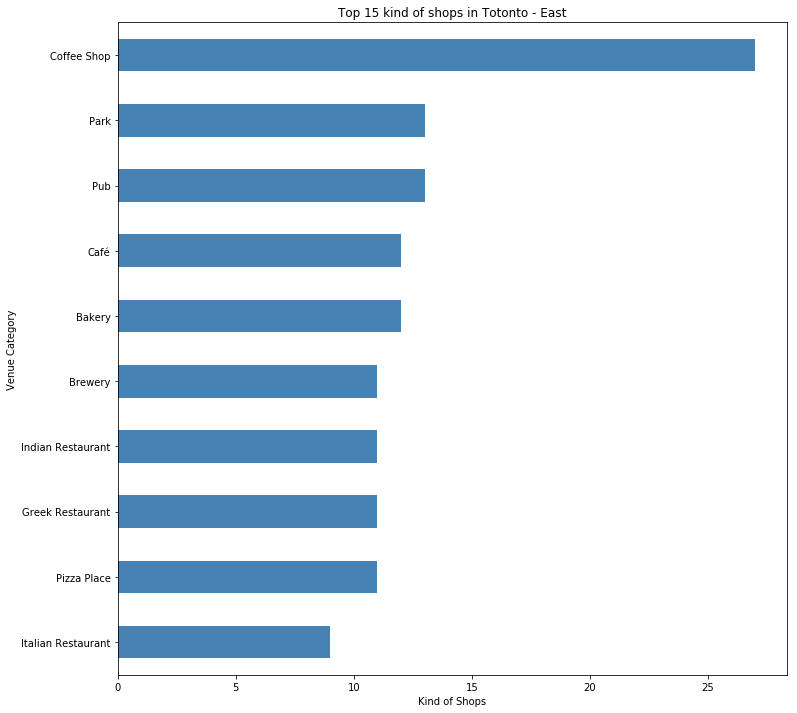

In [47]:
df_top10_east.plot(kind='barh', figsize=(12, 12), color='steelblue')
plt.xlabel('Kind of Shops')
plt.title('Top 15 kind of shops in Totonto - East')

plt.show()

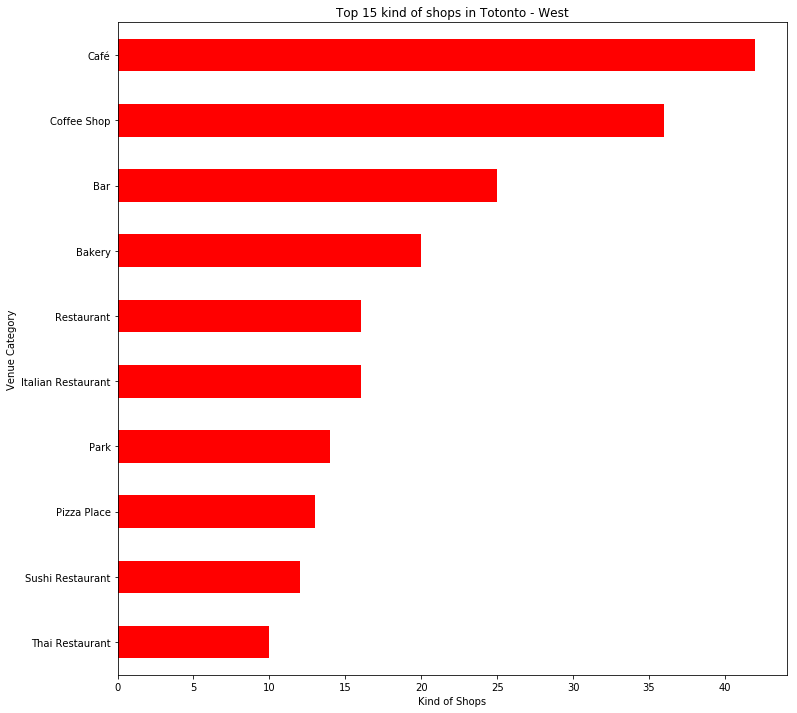

In [48]:
df_top10_west.plot(kind='barh', figsize=(12, 12), color='red')
plt.xlabel('Kind of Shops')
plt.title('Top 15 kind of shops in Totonto - West')

plt.show()